Inputted state name: KANSAS
The human risk level percentage shows the weighted average of the total number of deaths and injuries, both direct and indirect, from all storm events by year
The financial risk level percentage shows the weighted average of the total number of damaged crops and property, in dollars, from all storm events by year
The average human risk level percentage for all years is: 0.42
The average financial risk level percentage for all years is: 0.04
The human risk scale percentage shows the weighted average of the total number of deaths and injuries, both direct and indirect, for all years by storm event
The financial risk scale percentage shows the weighted average of the total number of damaged crops and property, in dollars, for all years by storm event
The average human risk scale percentage for all years is: 1.75
The average financial risk scale percentage for all years is: 1.75
Most frequent storm event type is Hail and can be seen in the map below.
Data below 

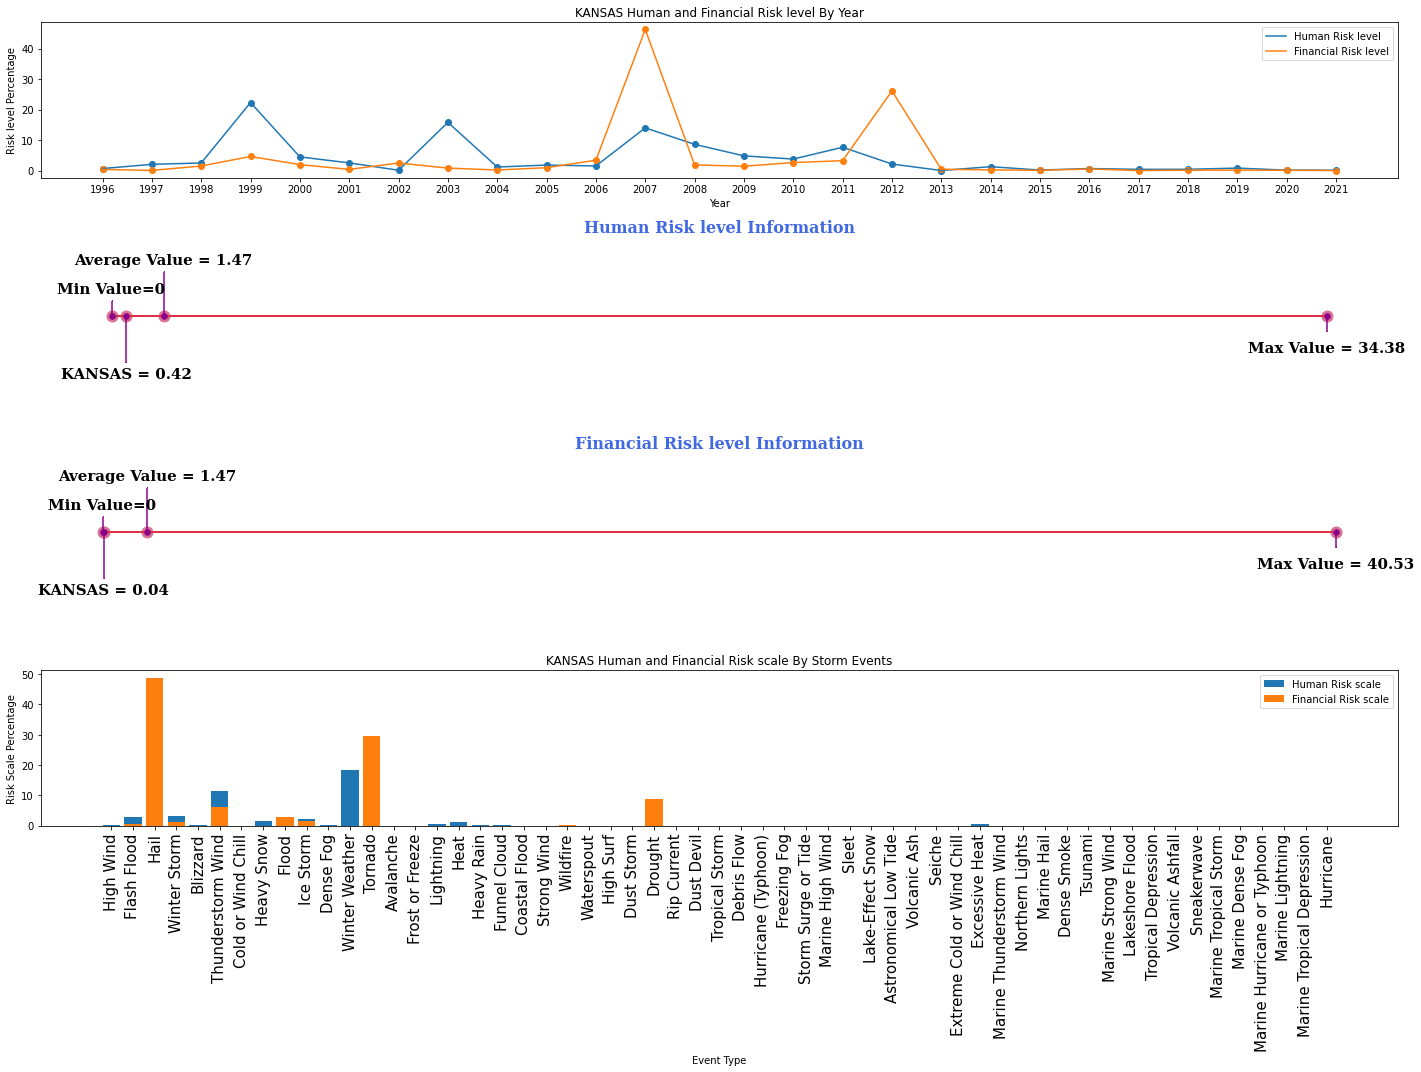

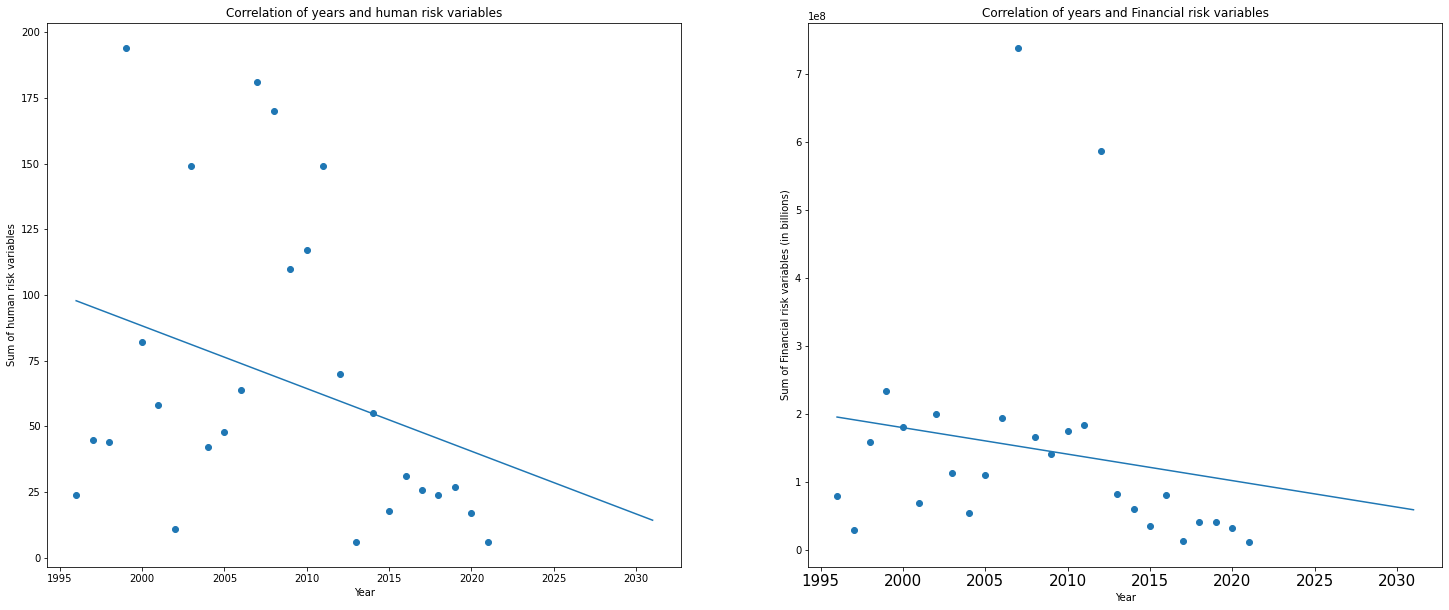

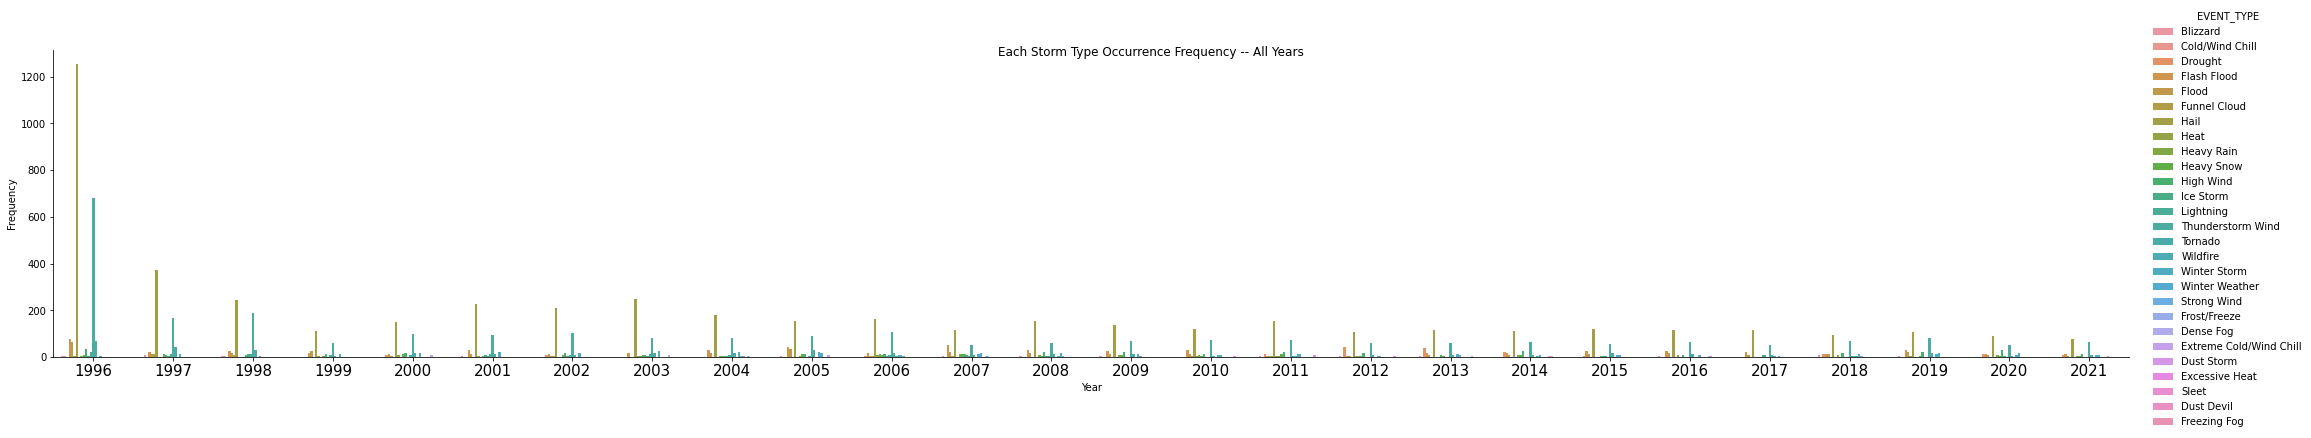

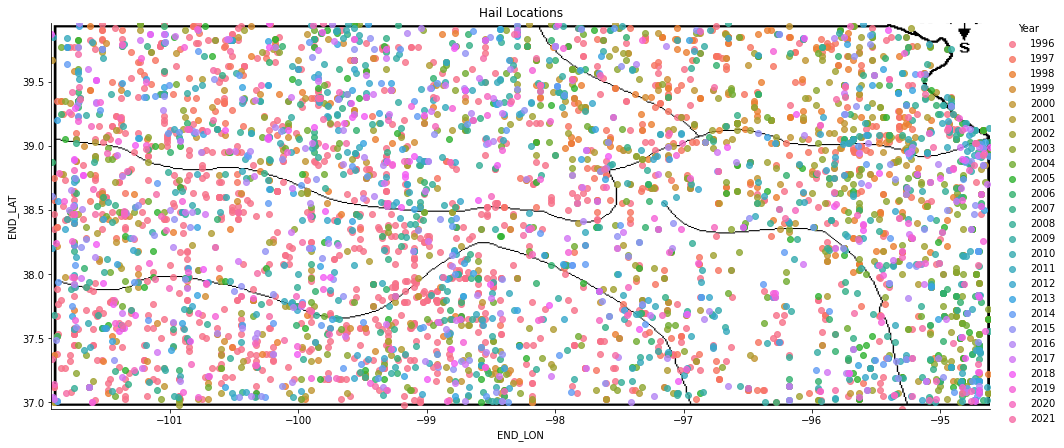

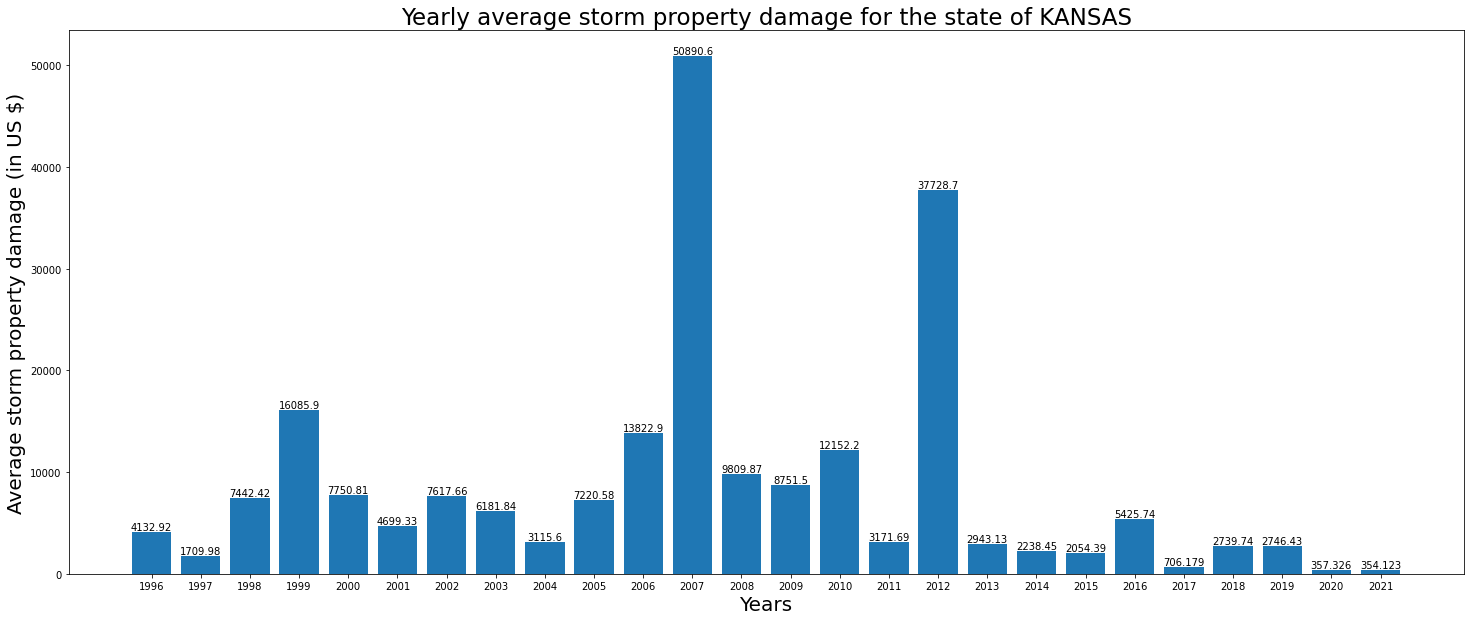

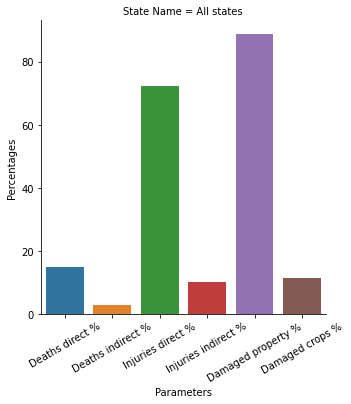

In [4]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import seaborn as sns
from tkinter import *
import math

#Tkinter code for getting the user to select from dropdown
all_states_df = pd.read_excel('state_names.xlsx', index_col=0, sheet_name='State Names')
all_event_types_df = pd.read_excel('event_types.xlsx', index_col=0, sheet_name='Event Types')
dec_options = ['Yes','No']
root = Tk()
root.geometry('400x150')
def on_selection_button():
    root.destroy()
state_selected = StringVar()
decision_selected = StringVar()
state_name_label = Label(root, text='Please select a state from below')
data_in_detail_label = Label(root, text='Would you like to see the breakdown of data in detail?')
state_selected.set(all_states_df['STATE'][1])
decision_selected.set('Yes')
state_name_dropdown = OptionMenu(root, state_selected, *all_states_df['STATE'])
data_in_detail_decision = OptionMenu(root, decision_selected, *dec_options)
data_in_detail_decision.config(width=10)
button = Button(root, text='Generate Data', command=on_selection_button)
state_name_label.pack()
state_name_dropdown.pack()
data_in_detail_label.pack()
data_in_detail_decision.pack()
button.pack()
root.mainloop()

state_name = state_selected.get()
data_in_detail_decision = decision_selected.get()

file_name = state_name.upper() + '.xlsx'
excel_sheets = pd.ExcelFile(file_name)
storm_risk_level_name = 'Storm Event Risk Level'
outputs_risk_level_name = 'Risk level Outputs'
if storm_risk_level_name not in excel_sheets.sheet_names:
    storm_risk_level_name = 'Storm Event Risk Scale'
if outputs_risk_level_name not in excel_sheets.sheet_names:
    outputs_risk_level_name = 'Risk Scale Outputs'


yearly_df = pd.read_excel(file_name, index_col=0, sheet_name='Yearly data')
parser = lambda date: datetime.strptime(date, '%Y%m')
data_df = pd.read_excel(file_name, index_col='BEGIN_YEARMONTH', sheet_name='Storms-locations data', parse_dates = ['BEGIN_YEARMONTH'], date_parser=parser)
data_df.drop('Unnamed: 0', inplace=True, axis = 1)
data_df['Year'] = data_df.index.year
bar_graph_data_df = data_df.reset_index()
bar_graph_data_df = bar_graph_data_df[['Year','EVENT_TYPE']].groupby(['Year', 'EVENT_TYPE']).value_counts().reset_index().rename({0:'Frequency'}, axis=1)
risk_level_df = pd.read_excel(file_name, index_col=0, sheet_name=outputs_risk_level_name)
total_percentages_df = pd.read_excel(file_name, index_col=0, sheet_name='Total Percentages')
risk_scale_storm_events_df = pd.read_excel(file_name, index_col=0, sheet_name=storm_risk_level_name)
correlation_percentages_df = pd.read_excel('correlation_averages.xlsx',index_col=0, sheet_name='Correlation averages in detail')
if data_in_detail_decision.lower() == 'no':
    correlation_percentages_df = correlation_percentages_df.loc[correlation_percentages_df['State Name'] == state_name.upper()]
    correlation_percentages_all_states_df = pd.read_excel('correlation_averages.xlsx', index_col=0, sheet_name='Correlation averages in Summary')
    correlation_percentages_df = pd.concat([correlation_percentages_df, correlation_percentages_all_states_df], axis=0)
    correlation_percentages_df.reset_index(drop=True, inplace=True)

first_frequent_storm = ''
second_frequent_storm = ''
display_geographical_map = True
frequent_storm_description = ''
frequent_storms = []
for i in range(1996, 2022):
    current_df = bar_graph_data_df.loc[bar_graph_data_df['Year']==i]
    maximum_frequency_of_a_storm = current_df['Frequency'].max()
    maximum_frequency_storm_name = current_df.loc[current_df['Frequency']==maximum_frequency_of_a_storm]['EVENT_TYPE']
    if len(maximum_frequency_storm_name) > 1:
        frequent_storms.append(maximum_frequency_storm_name.values[0])
        frequent_storms.append(maximum_frequency_storm_name.values[1])
    else:
        if not maximum_frequency_storm_name.empty:
            frequent_storms.append(maximum_frequency_storm_name.item())


frequent_storms_totals = dict()
for element in frequent_storms:
    if element not in frequent_storms_totals.keys():
        frequent_storms_totals[element] = 1
    else:
        frequent_storms_totals[element] += 1

first_frequent_storm = max(frequent_storms_totals, key=frequent_storms_totals.get)
frequent_storms_totals.pop(first_frequent_storm)
if len(frequent_storms_totals) == 0:
    second_frequent_storm = first_frequent_storm
else:
    second_frequent_storm = max(frequent_storms_totals, key=frequent_storms_totals.get)

most_common_storm_event_type = first_frequent_storm
frequent_storm_description = 'Most frequent storm event type is ' + most_common_storm_event_type
#Code for where in the states the most frequent storm event occurs
most_frequent_storm_locations_df = data_df.loc[
    (data_df['EVENT_TYPE']==first_frequent_storm) &
    (data_df['BEGIN_LAT']!=0) & (data_df['BEGIN_LON']!=0) &
    (data_df['END_LAT']!=0) & (data_df['END_LON']!=0) & (data_df['BEGIN_LAT'] < data_df['BEGIN_LAT'].quantile(0.99)) & (data_df['BEGIN_LAT'] > data_df['BEGIN_LAT'].quantile(0.01)) & (data_df['BEGIN_LON'] < data_df['BEGIN_LON'].quantile(0.99)) & (data_df['BEGIN_LON'] > data_df['BEGIN_LON'].quantile(0.01)) & (data_df['END_LAT'] < data_df['END_LAT'].quantile(0.99)) & (data_df['END_LAT'] > data_df['END_LAT'].quantile(0.01)) & (data_df['END_LON'] < data_df['END_LON'].quantile(0.99)) & (data_df['END_LON'] > data_df['END_LON'].quantile(0.01))
][['Year','BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON']]

if most_frequent_storm_locations_df.empty or len(most_frequent_storm_locations_df.index) < 5:
    most_frequent_storm_locations_df = data_df.loc[(data_df['EVENT_TYPE']==second_frequent_storm) &
        (data_df['BEGIN_LAT']!=0) & (data_df['BEGIN_LON']!=0) &
        (data_df['END_LAT']!=0) & (data_df['END_LON']!=0) & (data_df['BEGIN_LAT'] < data_df['BEGIN_LAT'].quantile(0.99)) & (data_df['BEGIN_LAT'] > data_df['BEGIN_LAT'].quantile(0.01)) & (data_df['BEGIN_LON'] < data_df['BEGIN_LON'].quantile(0.99)) & (data_df['BEGIN_LON'] > data_df['BEGIN_LON'].quantile(0.01)) & (data_df['END_LAT'] < data_df['END_LAT'].quantile(0.99)) & (data_df['END_LAT'] > data_df['END_LAT'].quantile(0.01)) & (data_df['END_LON'] < data_df['END_LON'].quantile(0.99)) & (data_df['END_LON'] > data_df['END_LON'].quantile(0.01))][['Year','BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON']]
    if most_frequent_storm_locations_df.empty or len(most_frequent_storm_locations_df.index) < 5:
        frequent_storm_description = frequent_storm_description + '. But there is no data to display for it.'
        display_geographical_map = False
    else:
        most_common_storm_event_type = second_frequent_storm
        frequent_storm_description = frequent_storm_description +  '. However no data was found for the most frequent storms locations. Instead, we display below the storm locations of the second most frequent storm, which is ' + most_common_storm_event_type + '.'
else:
    frequent_storm_description = frequent_storm_description + ' and can be seen in the map below.'

BBox = (
    most_frequent_storm_locations_df.END_LON.min(),
    most_frequent_storm_locations_df.END_LON.max(),
    most_frequent_storm_locations_df.END_LAT.min(),
    most_frequent_storm_locations_df.END_LAT.max()
)

#Risk level graph
fig, ax = plt.subplots(nrows=4, figsize=(20,15))
ax[0].plot(risk_level_df.index, risk_level_df['Human Risk level Output'],label='Human Risk level')
ax[0].scatter(risk_level_df.index, risk_level_df['Human Risk level Output'])
ax[0].plot(risk_level_df.index, risk_level_df['Financial Risk level Output'],label='Financial Risk level')
ax[0].scatter(risk_level_df.index, risk_level_df['Financial Risk level Output'])
ax[0].set_title(state_name.upper()+' Human and Financial Risk level By Year')
# ax[0].set_xlim(min(risk_level_df.index), max(risk_level_df.index))
ax[0].set_xticks(risk_level_df.index)
ax[0].legend()
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Risk level Percentage')
print('Inputted state name: '+ state_name)
print('The human risk level percentage shows the weighted average of the total number of deaths and injuries, both direct and indirect, from all storm events by year')
print('The financial risk level percentage shows the weighted average of the total number of damaged crops and property, in dollars, from all storm events by year')
average_risk_level_human = sum(risk_level_df['Human Risk level Output'])
average_risk_level_financial = sum(risk_level_df['Human Risk level Output'])
print('The average human risk level percentage for all years is: '+ str(round(total_percentages_df['Human'][0],2)))
print('The average financial risk level percentage for all years is: '+str(round(total_percentages_df['Financial'][0],2)))

label_offsets = [0.45, -0.45, 1, -0.7]
stems = [0.3, -0.3, 0.85, -0.3]
#HUMAN
if total_percentages_df['Human'][0] == 0:
    human_data = [0, total_percentages_df['Human'][0], 1.47, 34.38]
    human_labels = ['Min Value=0',state_name.upper() + ' = ' + str(round(total_percentages_df['Human'][0],2)),'Average Value = 1.47','Max Value = 34.38']
    label_offsets[1] = -1.20
    stems[1] = -0.9
elif total_percentages_df['Human'][0] <= 1.47:
    human_data = [0, total_percentages_df['Human'][0], 1.47, 34.38]
    human_labels = ['Min Value=0',state_name.upper() + ' = ' + str(round(total_percentages_df['Human'][0], 2)),'Average Value = 1.47','Max Value = 34.38']
    label_offsets[1] = -1.20
    stems[1] = -0.9
elif (total_percentages_df['Human'][0] > 1.47) and (total_percentages_df['Human'][0] <= (0.9*34.38)):
    human_data = [0, 1.47, total_percentages_df['Human'][0], 34.38]
    human_labels = ['Min Value=0','Average Value = 1.47',state_name.upper() + ' = ' + str(round(total_percentages_df['Human'][0], 2)),'Max Value = 34.38']
    label_offsets[2] = 1.20
    stems[2] = 0.9
else:
    human_data = [0, 1.47, total_percentages_df['Human'][0], 34.38]
    human_labels = ['Min Value=0','Average Value = 1.47',state_name.upper() + ' = ' + str(round(total_percentages_df['Human'][0], 2)),'Max Value = 34.38']
    label_offsets[2] = 1.20
    stems[2] = 0.9

ax[1].set_ylim(-1.5, 1.5)
ax[1].set_xlim(min(human_data)-2, max(human_data)+2)
ax[1].axhline(0, xmin=0.05, xmax=0.95, c='deeppink', zorder=1)
ax[1].scatter(human_data, np.zeros(len(human_data)), s=120, c='palevioletred', zorder=2)
ax[1].scatter(human_data, np.zeros(len(human_data)), s=30, c='darkmagenta', zorder=3)
label_offsets = np.array(label_offsets)
for i, (l, d) in enumerate(zip(human_labels, human_data)):
    _ = ax[1].text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='Black',fontsize=15)
stems = np.array(stems)
marker_line, stem_line, baseline = ax[1].stem(human_data, stems, use_line_collection=True)
_ = plt.setp(marker_line, marker=',', color='darkmagenta')
_ = plt.setp(stem_line, color='darkmagenta')
# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax[1].spines[spine].set_visible(False)
# hide tick labels
_ = ax[1].set_xticks([])
_ = ax[1].set_yticks([])
_ = ax[1].set_title('Human Risk level Information', fontweight="bold", fontfamily='serif', fontsize=16,
                    color='royalblue')

#FINANCIAL
if total_percentages_df['Financial'][0] == 0:
    financial_data = [0, total_percentages_df['Financial'][0], 1.47, 40.53]
    financial_labels = ['Min Value=0',state_name.upper() + ' = ' + str(round(total_percentages_df['Financial'][0],2)),'Average Value = 1.47','Max Value = 40.53']
    label_offsets[1] = -1.20
    stems[1] = -0.9
elif total_percentages_df['Financial'][0] <= 1.47:
    financial_data = [0, total_percentages_df['Financial'][0], 1.47, 40.53]
    financial_labels = ['Min Value=0',state_name.upper() + ' = ' + str(round(total_percentages_df['Financial'][0],2)),'Average Value = 1.47','Max Value = 40.53']
    label_offsets[1] = -1.20
    stems[1] = -0.9
elif (total_percentages_df['Financial'][0] > 1.47) and (total_percentages_df['Financial'][0] <= (0.9*40.53)):
    financial_data = [0, 1.47, total_percentages_df['Financial'][0], 40.53]
    financial_labels = ['Min Value=0','Average Value=1.47',state_name.upper()+ '=' + str(round(total_percentages_df['Financial'][0],2)),'Max Value = 40.53']
    label_offsets[2] = 1.20
    stems[2] = 0.9
else:
    financial_data = [0, 1.47, total_percentages_df['Financial'][0], 40.53]
    financial_labels = ['Min Value=0','Average Value=1.47',state_name.upper()+ '=' + str(round(total_percentages_df['Financial'][0],2)),'Max Value = 40.53']
    label_offsets[2] = 1.20
    stems[2] = 0.9

ax[2].set_ylim(-1.5, 1.5)
ax[2].axhline(0, xmin=0.05, xmax=0.95, c='deeppink', zorder=1)
ax[2].scatter(financial_data, np.zeros(len(financial_data)), s=120, c='palevioletred', zorder=2)
ax[2].scatter(financial_data, np.zeros(len(financial_data)), s=30, c='darkmagenta', zorder=3)
label_offsets = np.array(label_offsets)
for i, (l, d) in enumerate(zip(financial_labels, financial_data)):
    _ = ax[2].text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='Black',fontsize=15)
stems = np.array(stems)
marker_line, stem_line, baseline = ax[2].stem(financial_data, stems, use_line_collection=True)
_ = plt.setp(marker_line, marker=',', color='darkmagenta')
_ = plt.setp(stem_line, color='darkmagenta')
# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax[2].spines[spine].set_visible(False)
# hide tick labels
_ = ax[2].set_xticks([])
_ = ax[2].set_yticks([])
_ = ax[2].set_title('Financial Risk level Information', fontweight="bold", fontfamily='serif', fontsize=16,
                 color='royalblue')
# fig.tight_layout()

average_risk_Scale_human = sum(risk_scale_storm_events_df['Human'])/57
average_risk_Scale_financial = sum(risk_scale_storm_events_df['Financial'])/57

if math.isnan(average_risk_Scale_human):
    average_risk_Scale_human = 0
if math.isnan(average_risk_Scale_financial):
    average_risk_Scale_financial = 0

print('The human risk scale percentage shows the weighted average of the total number of deaths and injuries, both direct and indirect, for all years by storm event')
print('The financial risk scale percentage shows the weighted average of the total number of damaged crops and property, in dollars, for all years by storm event')
print('The average human risk scale percentage for all years is: '+ str(round(average_risk_Scale_human,2)))
print('The average financial risk scale percentage for all years is: '+str(round(average_risk_Scale_financial,2)))

#Risk level Grouped bar chart
ax[3].bar(risk_scale_storm_events_df.index, risk_scale_storm_events_df['Human'], label='Human Risk scale')
ax[3].bar(risk_scale_storm_events_df.index, risk_scale_storm_events_df['Financial'], label='Financial Risk scale')
ax[3].set_xticks(risk_scale_storm_events_df.index)
ax[3].set_xticklabels(risk_scale_storm_events_df.index, rotation=90)
ax[3].set_xlabel('Event Type')
ax[3].set_ylabel('Risk Scale Percentage')
ax[3].legend()
# ax[3].bar_label(ax[3].containers[0])
ax[3].set_title(state_name.upper()+' Human and Financial Risk scale By Storm Events')
plt.xticks(fontsize=15)
fig.tight_layout()
#______________________________________________________________________________________________________________________________________________

fig1, ax = plt.subplots(ncols=2, figsize=(25,10))

#Projecting the data for next 10 years (i.e.: up to year 2031)
#For human linear regression
yearly_df['Sum of Human'] = yearly_df['states_total_injuries_direct'] + yearly_df['states_total_injuries_indirect'] + yearly_df['states_total_deaths_direct'] + yearly_df['states_total_deaths_indirect']

ax[0].scatter(x=yearly_df.index, y=yearly_df['Sum of Human'])
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Sum of human risk variables')
ax[0].set_title('Correlation of years and human risk variables')
human_variables_lin_regress = linregress(x=yearly_df.index, y=yearly_df['Sum of Human'])

#For Financial linear regression
yearly_df['Sum of Financial'] = yearly_df['states_total_damaged_property'] + yearly_df['states_total_damaged_crops']
ax[1].scatter(x=yearly_df.index, y=yearly_df['Sum of Financial'])
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Sum of Financial risk variables (in billions)')
ax[1].set_title('Correlation of years and Financial risk variables')

plt.xticks(fontsize=15)

financial_variables_lin_regress = linregress(x=yearly_df.index, y=yearly_df['Sum of Financial'])

extension_of_x_axis = yearly_df.index

for k in range(extension_of_x_axis.values[-1]+1, 2032):
    extension_of_x_axis = np.append(extension_of_x_axis, [k])
ax[0].plot(extension_of_x_axis, human_variables_lin_regress.intercept+human_variables_lin_regress.slope*extension_of_x_axis)
ax[1].plot(extension_of_x_axis, financial_variables_lin_regress.intercept+financial_variables_lin_regress.slope*extension_of_x_axis)
# ax[0][0].tick_params(axis='x', labelrotation=90)
# ax[0][1].set_xticks(extension_of_x_axis, rotation=45)
yearly_df.drop(['Sum of Human', 'Sum of Financial'], inplace=True, axis=1)

#Bar graphs for Event types in the years and their frequency throughout the year
if data_in_detail_decision.lower() == 'yes':
    figure2, ax = plt.subplots(nrows=13, ncols=2, figsize=(25, 130))
    year = 1996
    for i in range(0, 13):
        for j in range(0, 2):
            bar_graph_data_year_df = bar_graph_data_df.copy().loc[bar_graph_data_df['Year'] == year]
            if not bar_graph_data_year_df.empty:
                title_name = 'Each Storm Type Occurrence Frequency for year ' + str(year)
                sns.barplot(x='EVENT_TYPE', y='Frequency', data = bar_graph_data_year_df, ax=ax[i][j], ci=None)
                ax[i][j].set_title(title_name)
                ax[i][j].bar_label(ax[i][j].containers[0])
                ax[i][j].set_xticklabels(ax[i][j].get_xticklabels(), rotation=40, ha='right')
            year += 1
    plt.tight_layout()
else:
    figure2 = sns.catplot(x='Year',y='Frequency', data=bar_graph_data_df, kind='bar', hue='EVENT_TYPE', aspect=6).figure
    figure2.suptitle('Each Storm Type Occurrence Frequency -- All Years')
    plt.xticks(fontsize=15)

figure3=''

print(frequent_storm_description)

if display_geographical_map:
    #Where most frequent storm occurs
    # figure3, ax = plt.subplots(figsize=(25,25))
    # read the image of a state
    locations_plot = sns.lmplot(x='END_LON', y='END_LAT', data=most_frequent_storm_locations_df, hue='Year', fit_reg=False, height=14, aspect=1, facet_kws={'legend_out': True})
    figure3 = locations_plot.figure
    ax = locations_plot.ax
    image_file = state_name.lower().replace(' ', '')+'.PNG'
    ohio_img = plt.imread(image_file)
    ax.set_title(most_common_storm_event_type + ' Locations')
    ax.set_xlim(BBox[0], BBox[1])
    ax.set_ylim(BBox[2], BBox[3])
    ax.imshow(ohio_img, zorder=0, extent = BBox, aspect='equal')

#Visualization below provides potential solution to the visualization goal: Find out what the yearly average storm property damage is for each state
#(This visualization goal is to be changed however)
#Running a query in MySQL Workbench 'select count(distinct EVENT_ID) from `stormdata`; gives an output of 352637.
#Using this value, it was then divided by 26 (number of years 1996 to 2021), to get
# math.floor(352637/26) = 13562 average storm event occurrences per year.
#Data below generates a single bar graph visual that displays yearly average property for currently viewed state:

print('Data below shows what the yearly average storm property damage is for each state')
figure5, ax5 = plt.subplots(figsize=(25, 10))
ax5.bar(yearly_df.index, (yearly_df['states_total_damaged_property'] / 13562))
ax5.set_title('Yearly average storm property damage for the state of '+ state_name, fontsize=23)
ax5.bar_label(ax5.containers[0])
ax5.set_xticks(yearly_df.index, fontsize=15)
ax5.set_xticklabels(yearly_df.index)
ax5.set_xlabel('Years', fontsize=20)
ax5.set_ylabel('Average storm property damage (in US $)', fontsize=20)

print('Highest average damaged property cost for the state of '+ state_name+ ' happened in the year ' + str(yearly_df.loc[yearly_df['states_total_damaged_property'] == max(yearly_df['states_total_damaged_property'])].index.values[0]) + ' and it was $' + str(math.floor(yearly_df.loc[yearly_df['states_total_damaged_property'] == max(yearly_df['states_total_damaged_property'])]['states_total_damaged_property'].values[0] / 13562)))

#Visualization below is for the visual goal 'Seeing correlation between states and property damage/fatalities/injuries'.
if data_in_detail_decision.lower() == 'yes':
    correlation_plots = sns.catplot(x='Parameters', y='Percentages', data=correlation_percentages_df, kind='bar', col='State Name', col_wrap=4)
    figure6 = correlation_plots.figure
    correlation_plots.set_xticklabels(rotation=30)
else:
    correlation_plots = sns.catplot(x='Parameters', y='Percentages', data=correlation_percentages_df, kind='bar', col='State Name')
    figure6 = correlation_plots.figure
    correlation_plots.set_xticklabels(rotation=30)

In [5]:
#Clearing the visuals from the memeory heap
fig.clear()
fig1.clear()
figure2.clear()
if figure3 != '':
    figure3.clear()
    plt.close(figure3)
figure5.clear()
figure6.clear()
plt.close(fig)
plt.close(fig1)
plt.close(figure2)
plt.close(figure5)
plt.close(figure6)